# Statistical Machine Translation

If you have seen the SMT lecture, you already know what the task of machine translation is and what word alignment is. With the help of this notebook, let's try to figure it all out in practice.

# IBM MODEL 1

1.We need to calculate $$p(f,a|e,m)=\frac{p(f,a|e,m)}{\sum_{a \in A} p(f,a|e,m)}$$
* English pairs consist of: $l=2$ words.  
* German pairs: $m=2$  
* Alignment $a$ is {${a_{1},..., a_{m}}$}, where each $a_{j} \in {0,...,l}$
<F>

2.There are $(l+1)^m$ possible alignments. And in IBM1 all allignments $a$ are equally likely:
$$p(a|e,m) = \frac{1}{(l+1)^m}$$
<F>
3.To generate a German string $f$ from an English string $e$:  
* Step 1: Pick an alignment $a$ with probability: $\frac{1}{(l+1)^m}$  
* Step 2: Pick the German words with probs: $$p(f|a,e,m)={\prod_{j=1}^{m} t(f_{j}|e_{a_{j}})}$$

4.The final result:  $$p(f,a|e,m)=p(a|e,m)\times{p(f|a,e,m)}=\frac{1}{(l+1)^m}{\prod_{j=1}^{m} t(f_{j}|e_{a_{j}})}$$


## Statistical Machine Translation in Python 3 with NLTK

Original: https://notebook.community/dcavar/python-tutorial-for-ipython/notebooks/Machine%20Translation%20in%20Python%203%20with%20NLTK

In [ ]:
import nltk
from nltk.corpus import comtrans

We can load a word-level alignment corpus for English and French from the NLTK dataset:

In [ ]:
nltk.download('comtrans')
nltk.download('punkt')

[nltk_data] Downloading package comtrans to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
words = comtrans.words("alignment-en-fr.txt")

Print out the words in the corpus as a list:

In [ ]:
for word in words[:20]:
    print(word)
print("...")

Resumption
of
the
session
I
declare
resumed
the
session
of
the
European
Parliament
adjourned
on
Friday
17
December
1999
,
...


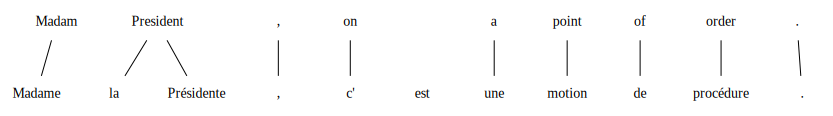

In [ ]:
als = comtrans.aligned_sents("alignment-en-fr.txt")[10]
als

The alignments can be accessed via the alignment property:

In [ ]:
als.alignment

Alignment([(0, 0), (1, 1), (1, 2), (2, 3), (3, 4), (4, 6), (5, 7), (6, 8), (7, 9), (8, 10)])

We can display the alignment using the invert function:

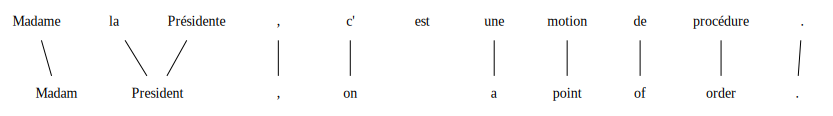

In [ ]:
als.invert()

We can also create alignments directly using the NLTK translate module. We import the translation modules from NLTK:

In [ ]:
from nltk.translate import Alignment, AlignedSent

We can create an alignment example:

In [ ]:
als = AlignedSent( ["Reprise", "de", "la", "session" ], \
    ["Resumption", "of", "the", "session" ] , \
    Alignment( [ (0 , 0), (1 , 1), (2 , 2), (3 , 3) ] ) )

## Translating with IBM Model 1 in NLTK

We already imported comtrans from NLTK in the code above. We have to import IBMModel1 from nltk.translate:

In [ ]:
from nltk.translate import IBMModel1
import numpy as np
import nltk

We can create an IBMModel1 using 20 iterations to run the learning algorithm using the first 10 sentences from the aligned corpus; see the EM explanation on the slides and the following publications:



*   Philipp Koehn. 2010. Statistical Machine Translation. Cambridge University Press, New York.
*   Peter E Brown, Stephen A. Della Pietra, Vincent J. Della Pietra, and Robert L. Mercer. 1993. The Mathematics of Statistical Machine Translation: Parameter Estimation. Computational Linguistics, 19 (2), 263-311.



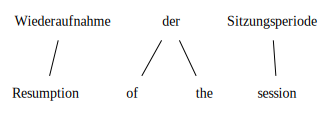

In [ ]:
comtrans.aligned_sents()[0]

In [ ]:
com_ibm1 = IBMModel1(comtrans.aligned_sents()[:100], 20)

In [ ]:
com_ibm1.translation_table["bitte"]

defaultdict(<function nltk.translate.ibm1.IBMModel1.set_uniform_probabilities.<locals>.<lambda>()>,
            {None: 1e-12,
             'Please': 0.23411716753470124,
             'rise': 0.23411716753470124,
             ',': 2.013585441185218e-06,
             'then': 0.04787841160207327,
             'for': 3.1761546037985005e-10,
             'this': 4.347173180406405e-08,
             'minute': 0.00018442026758979944,
             "'": 1.4423826907387919e-08,
             's': 2.570357725939981e-07,
             'silence': 0.00018442026758979944,
             '.': 1.426827150712763e-12,
             'I': 7.37602607664982e-11,
             'would': 0.05406503202758656,
             'ask': 0.48521709688115267,
             'that': 2.308247189554263e-11,
             'they': 9.088937186752897e-05,
             'reconsider': 0.00041728526710854333,
             'since': 2.21126362285639e-06,
             'is': 1.0092731231569363e-10,
             'not': 1e-12,
             'the': 1

In [ ]:
print(round(com_ibm1.translation_table["bitte"]["Please"], 3) )

0.234


In [ ]:
print(round(com_ibm1.translation_table["Sitzungsperiode"]["session"] , 3) )

0.997


In [ ]:
def translate(model, input_sentence):
  words = nltk.word_tokenize(input_sentence)
  result = []
  for word in words:
    translation_table = com_ibm1.translation_table[word]
    result.append(max(translation_table, key=translation_table.get))
  return " ".join(result)


In [ ]:
translate(com_ibm1, "Wiederaufnahme der Sitzungsperiode")

'Resumption of session'

## Machine Translation with Recurrent Neural Networks



Source: HSE University

Let us consider a sequence-to-sequence model for translation the dates in different format.

Train an Encoder-Decoder model based on RNN.

Configure GPU hardware accelerator (Runtime -> Change Runtime -> GPU)

Install the necessary libraries.



In [ ]:
%matplotlib inline

In [ ]:
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### 1. Generate a dataset

In [ ]:
import datetime
from random import randrange
from datetime import timedelta

In [ ]:
def get_random_date(start, end):
    delta = end - start
    int_delta = (delta.days * 24 * 60 * 60) + delta.seconds
    random_second = randrange(int_delta)
    return (start + timedelta(seconds=random_second)).replace(hour=0, minute = 0, second=0)


FORMATS = ['%d %b %Y', '%d %B %Y', '%B %dth, %Y', '%b %d, %Y',
           '%d/%m/%Y', '%d/%m/%y', '%d-%b-%y', '%d.%m.%Y']

TARGET_FORMAT = '%d-%m-%Y'

def get_dataset(fst_dt, snd_dt, fmt_dt):
    fst_d = datetime.datetime.strptime(fst_dt, fmt_dt)
    snd_d = datetime.datetime.strptime(snd_dt, fmt_dt)
    dataset = []
    for i in range(10000):
        date_format = random.choice(FORMATS)
        rand_dt = get_random_date(fst_d, snd_d)
        t = (datetime.datetime.strftime(rand_dt, date_format),
            datetime.datetime.strftime(rand_dt, TARGET_FORMAT))
        dataset.append(t)
    return dataset

dataset = get_dataset('1/1/2017', '1/1/2019', '%m/%d/%Y')

In [ ]:
dataset[:10]

[('October 12th, 2018', '12-10-2018'),
 ('May 20, 2018', '20-05-2018'),
 ('22 September 2017', '22-09-2017'),
 ('28 March 2018', '28-03-2018'),
 ('11 Jun 2018', '11-06-2018'),
 ('19 January 2018', '19-01-2018'),
 ('27 Apr 2017', '27-04-2017'),
 ('18.09.2017', '18-09-2017'),
 ('March 24th, 2018', '24-03-2018'),
 ('04/09/18', '04-09-2018')]

### 2. Create a helper class for word2index, index2word

In [ ]:
# the longest string length + EOS token
MAX_LENGTH = max(map(lambda x: len(x[0]), dataset)) + 1

In [ ]:
MAX_LENGTH

21

In [ ]:
SOS_token = 0  # start of sentence
EOS_token = 1  # end of sentence

# in our case token is a symbol
class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # SOS and EOS

    def addSentence(self, sentence):
        for word in list(sentence):
            self.addWord(word)

    def addWord(self, word): # update token dict
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.index2word[self.n_words] = word
            self.n_words += 1

In [ ]:
def readLangs(lang1, lang2):
    input_lang = Lang(lang1) # source dates
    output_lang = Lang(lang2) # target dates
    return input_lang, output_lang


def prepareData(lang1, lang2, pairs):
    input_lang, output_lang = readLangs(lang1, lang2)
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('human', 'iso', dataset)
print(random.choice(pairs))

human 43
iso 13
('09.03.2017', '09-03-2017')


In [ ]:
input_lang.word2index

{'O': 2,
 'c': 3,
 't': 4,
 'o': 5,
 'b': 6,
 'e': 7,
 'r': 8,
 ' ': 9,
 '1': 10,
 '2': 11,
 'h': 12,
 ',': 13,
 '0': 14,
 '8': 15,
 'M': 16,
 'a': 17,
 'y': 18,
 'S': 19,
 'p': 20,
 'm': 21,
 '7': 22,
 'J': 23,
 'u': 24,
 'n': 25,
 '9': 26,
 'A': 27,
 '.': 28,
 '4': 29,
 '/': 30,
 'D': 31,
 '6': 32,
 'i': 33,
 'l': 34,
 '-': 35,
 'N': 36,
 'v': 37,
 '5': 38,
 '3': 39,
 'F': 40,
 'g': 41,
 's': 42}

### 3. The Seq2Seq Model

Source code: https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html
- A model consists of two RNNs: an encoder and a decoder. Encoder reads the sentence and outputs a vector (encoded sentence), decoder reads this vector and generates the sentence; We are going to use [GRU cells](https://paperswithcode.com/method/gru)
- add EOS token to the end of the original sentence (its vector representation, getting after applying encoder - and there is a vector, which we will give in decoder);
- SOS token is fed to the input of decoder as the first character, and EOS token embedding from encoder is fed as the initial hidden state.

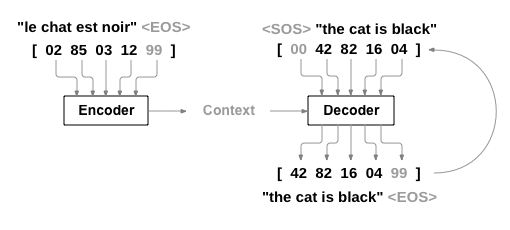

In [ ]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

### 4. Attention Decoder

What is attention and how does it work? [Read here](https://lena-voita.github.io/nlp_course/seq2seq_and_attention.html#attention_idea)

Attention mechanism allows a decoder to look at different parts of the sentence when generating your output.
- compute attention weights
- then multiply them with an encoder hidden state (``attn_applied``)


In [ ]:
# attention decoder
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):

        embedded = self.embedding(input).view(1, 1, -1)
        # embedded:  torch.Size([1, 1, 256])
        # hidden:  torch.Size([1, 1, 256])
        embedded = self.dropout(embedded)

        # replace with a new score function
        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1) # calculate attention
        # attn_weights:  torch.Size([1, 21]) i.e. weight for each input seq token
        # encoder_outputs: torch.Size([21, 256]) i.e. embedding for each input seq token
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),   # dot product for matrices
                                 encoder_outputs.unsqueeze(0))
        # attn_applied:  torch.Size([1, 1, 256])

        output = torch.cat((embedded[0], attn_applied[0]), 1) # concatenate embeddings and attention
        # output:  torch.Size([1, 512])
        output = self.attn_combine(output).unsqueeze(0)  # add linear transformation
        # attn_combine:  torch.Size([1, 1, 256])

        output = F.relu(output) # add activation
        output, hidden = self.gru(output, hidden)  # add rnn step

        output = F.log_softmax(self.out(output[0]), dim=1)  # output
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

### 5. Training
- create input tensors (with symbol index) from each pair in the training set
- add EOS tokens both to source and target


In [ ]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in list(sentence)]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [ ]:
# "Teacher forcing" - conception
# https://machinelearningmastery.com/teacher-forcing-for-recurrent-neural-networks/
teacher_forcing_ratio = 0.5

# for single input sample
def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    # iterate over all tokens in input sequence to train encoder
    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)
    # initiate decoder hidden state with encoder hidden state
    decoder_hidden = encoder_hidden

    use_teacher_forcing = False
    # use it for some iterations
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # for each decoder step we calculate loss on predictions but pass true values forward
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)

            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [ ]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]

    # https://towardsdatascience.com/cross-entropy-negative-log-likelihood-and-all-that-jazz-47a95bd2e81
    criterion = nn.NLLLoss()  # The negative log likelihood loss

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('(%d %d%%) %.4f' % (iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

### Plotting results

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

### 6. Quality Evaluation

In [ ]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]


You can look at a couple of sentences from the training sample and assess the quality.






In [ ]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ''.join(output_words)
        print('<', output_sentence)
        print('')

### 7. Start training

(500 10%) 1.2439
(1000 20%) 0.6545
(1500 30%) 0.4764
(2000 40%) 0.2994
(2500 50%) 0.1994
(3000 60%) 0.1648
(3500 70%) 0.1303
(4000 80%) 0.1097
(4500 90%) 0.1188
(5000 100%) 0.0866


<Figure size 640x480 with 0 Axes>

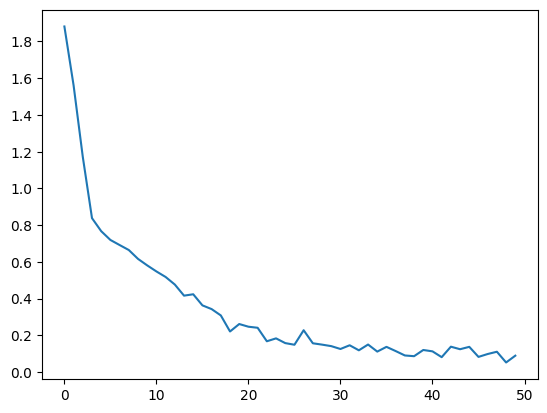

In [ ]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

trainIters(encoder1, attn_decoder1, 5000, print_every=500)

In [ ]:
evaluateRandomly(encoder1, attn_decoder1)

> 13/06/17
= 13-06-2017
< 13-06-2017<EOS>

> 23/01/18
= 23-01-2018
< 23-01-2018<EOS>

> 12/09/18
= 12-09-2018
< 12-09-2018<EOS>

> 02/01/17
= 02-01-2017
< 02-01-2017<EOS>

> 11-Aug-17
= 11-08-2017
< 11-08-2017<EOS>

> 18/09/17
= 18-09-2017
< 18-09-2017<EOS>

> 30 June 2017
= 30-06-2017
< 30-07-2017<EOS>

> 03/04/2018
= 03-04-2018
< 03-04-2018<EOS>

> 30/08/2018
= 30-08-2018
< 30-08-2018<EOS>

> October 08th, 2017
= 08-10-2017
< 05-10-2017<EOS>



### 8.  Attention visualization

For transformer models use [BertViz](https://github.com/jessevig/bertviz)

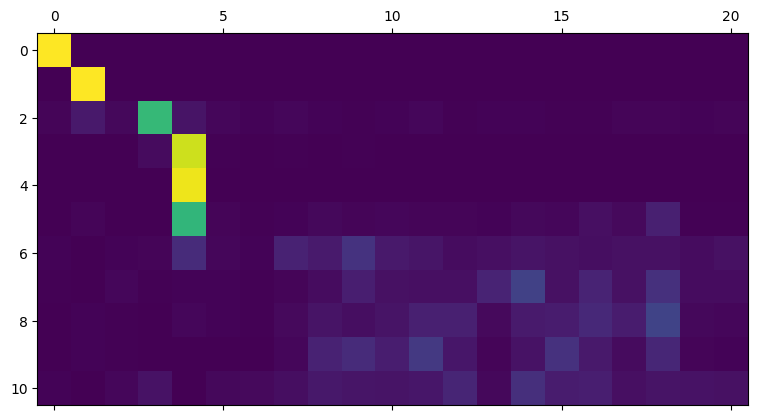

In [ ]:
output_words, attentions = evaluate(
    encoder1, attn_decoder1, "05 October 2017")
plt.matshow(attentions.numpy())

In [ ]:
output_words

['0', '5', '-', '1', '0', '-', '2', '0', '1', '7', '<EOS>']

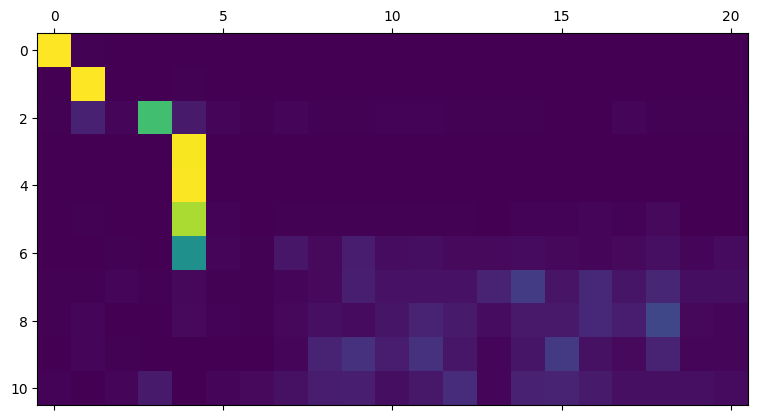

In [ ]:
output_words, attentions = evaluate(
    encoder1, attn_decoder1, "05.10.2017")
plt.matshow(attentions.numpy())

In [ ]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar

    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + list(input_sentence) +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()



def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ''.join(list(output_words)))
    showAttention(input_sentence, output_words, attentions)

input = February 22th, 2018
output = 22-02-2018<EOS>


<ipython-input-42-6edc18ede701>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + list(input_sentence) +
<ipython-input-42-6edc18ede701>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output_words)


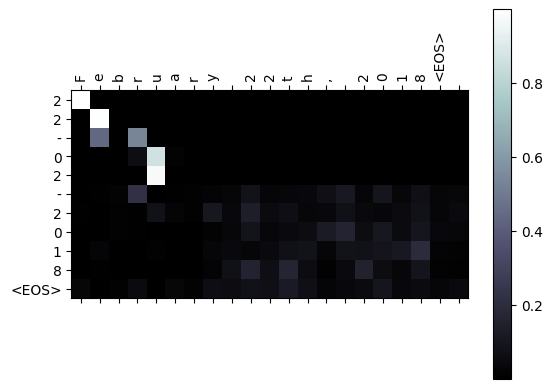

In [ ]:
evaluateAndShowAttention("February 22th, 2018")

input = 04/01/2018
output = 04-01-2018<EOS>


<ipython-input-42-6edc18ede701>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + list(input_sentence) +
<ipython-input-42-6edc18ede701>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output_words)


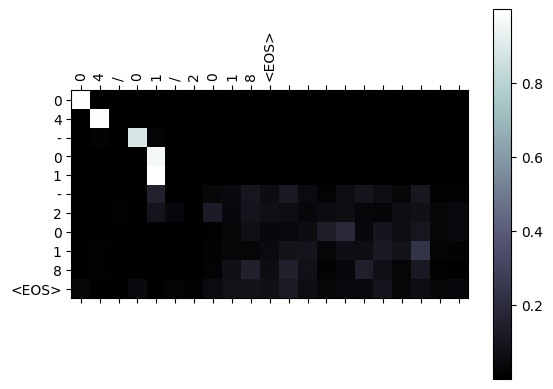

In [ ]:
evaluateAndShowAttention("04/01/2018")

input = December 17th, 2018
output = 11-12-2018<EOS>


<ipython-input-42-6edc18ede701>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + list(input_sentence) +
<ipython-input-42-6edc18ede701>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output_words)


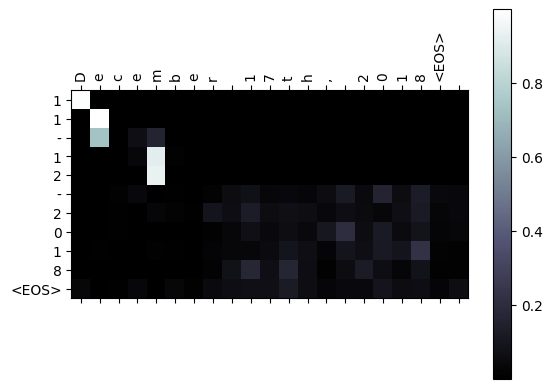

In [ ]:
evaluateAndShowAttention("December 17th, 2018")

input = Feb 03, 2018
output = 07-02-2018<EOS>


<ipython-input-42-6edc18ede701>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + list(input_sentence) +
<ipython-input-42-6edc18ede701>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output_words)


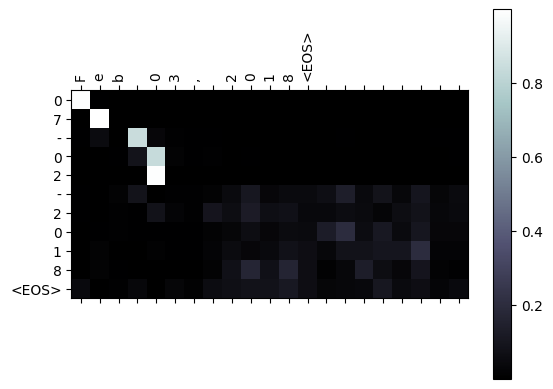

In [ ]:
evaluateAndShowAttention("Feb 03, 2018")


### 9. Evaluate the model on test set

In [ ]:
dataset_test = get_dataset('1/1/2017', '1/1/2019', '%m/%d/%Y')

In [ ]:
len(dataset_test)

10000

In [ ]:
def accuracy_on_test(encoder, decoder, dataset_test):
    i = 0
    n = 0
    for pair in dataset_test:
        pred = []
        # pair[1] - target
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ''.join(output_words)
        # output_sentence - pred
        n += 1
        i += int(output_sentence[:10]== pair[1][:10])
    return i*1. /n


BLEU metric

In [ ]:
!pip install sacrebleu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.6/106.6 kB 3.0 MB/s eta 0:00:00


In [ ]:
import sacrebleu

def bleu_on_test(encoder, decoder, dataset_test):
    i = 0
    n = 0
    translated = []
    target = []
    for pair in dataset_test:
        pred = []
        # pair[1] - target
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ''.join(output_words)
        # output_sentence - pred
        translated.append(output_sentence[:10])
        target.append(pair[1])
    bleu = sacrebleu.corpus_bleu(translated, [target])
    return bleu.score

In [ ]:
accuracy = accuracy_on_test(encoder1, attn_decoder1, dataset_test[:100])
print(accuracy)

0.72


In [ ]:
bleu = bleu_on_test(encoder1, attn_decoder1, dataset_test[:100])
print(bleu)

87.36326463765838


The better mentric to more complex seq2seq tasks might be [BERTScore](https://huggingface.co/spaces/evaluate-metric/bertscore)

### Exercise 1

Replace the score function in Attention layer following the tutorial https://pytorch.org/tutorials/beginner/deploy_seq2seq_hybrid_frontend_tutorial.html#define-decoders-attention-module

Train a model with a new Decoder

(500 10%) 1.2520
(1000 20%) 0.6215
(1500 30%) 0.4150
(2000 40%) 0.1915
(2500 50%) 0.1798
(3000 60%) 0.1170
(3500 70%) 0.1259
(4000 80%) 0.1455
(4500 90%) 0.1053
(5000 100%) 0.0958


<Figure size 640x480 with 0 Axes>

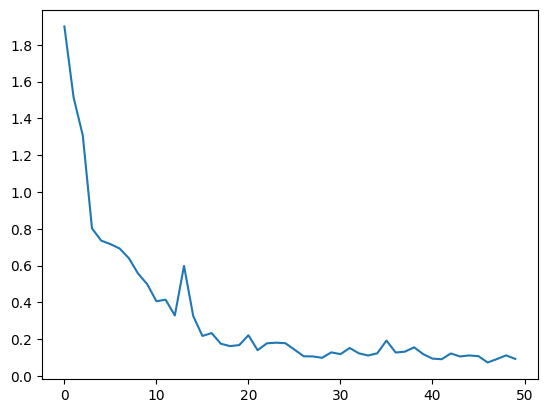

In [ ]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

trainIters(encoder1, attn_decoder1, 5000, print_every=500)

Let's see how the attention quotients have changed.



input = December 17th, 2018
output = 05-12-2018<EOS>


<ipython-input-42-6edc18ede701>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + list(input_sentence) +
<ipython-input-42-6edc18ede701>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output_words)


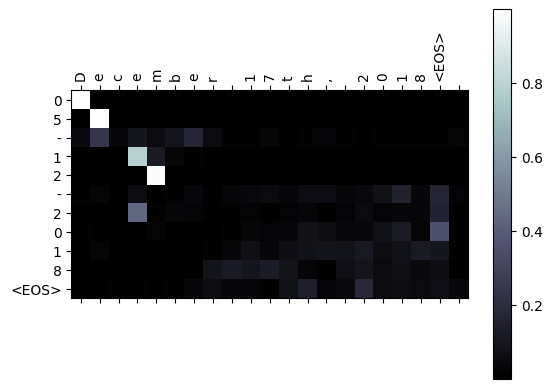

In [ ]:
evaluateAndShowAttention("December 17th, 2018")

Now the sequence is decoded correctly.



Try to change the functions score to 'dot' and 'concat' in the tutorial.

### Exercise 2

Replace AttnDecoderRNN with simple DecoderRNN


In [ ]:
# simple decoder
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

### Exercise 3

Implement bidirectional GRU in Encoder following
https://discuss.pytorch.org/t/about-bidirectional-gru-with-seq2seq-example-and-some-modifications/15588